# Classifier for the First 151 Pokémon using Transfer Learning

In this notebook we use Pytorch and transfer learning with pretrained models (ResNet152, MobileNetV2 and MobileNetV3 large). Then, we'll compare all the results and plot them.

## 0. Environment Setup

Import all necessary modules.

In [1]:
%matplotlib inline
#%load_ext tensorboard
#%tensorboard --logdir=runs

import copy
import glob
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms


#writer = SummaryWriter()

plt.ion()   # interactive mode

## 1. Load Data

We will use `torchvision` and `torch.utils.data` packages for loading the
data.

We have to train a model to classify Pokémon. There are 151 classes, with an average number of 79 images per class.
This is a small dataset (if we compare with most popular datasets).
We'll use _transfer learning_ for this task.

### 1.1 Dataset split

The dataset must be already splitted into
- **Training set (`train` folder)**: set of samples used during the learning process and it's used to learn the parameters (i.e. weights and biases).
- **Validation set (`val` folder)**: set of samples used to tune the hyperparameters (i.e. the architecture) of the classifier. It should follow the same probability distribution as the training data set. 
- **Test set (`test` folder)**: set of samples used to see the performance of the classifier. It should follow the same probability distribution as the training data set. 

### 1.2 Data preprocessing
Before feeding the images into the network, we need to normalize them, such that they have zero-mean and unitary standard deviation: 
$ \tilde x = (x-\mu_x)/\sigma_x$

First of all, we need to compute the mean and the standard deviation for each RGB channel. 
In particular, we use only images from the training set, to avoid exploiting test information.

In [58]:
train_dir = "/app/src/PokemonData/train"
train_mean = []
train_std = []

for class_dir in glob.glob(train_dir + "/*"):
    for sample_path in glob.glob(class_dir + "/*.jpg"):
        # Load image
        img = Image.open(sample_path)
        img = img.resize((224, 224), Image.ANTIALIAS)
        img = np.asarray(img, dtype=np.float32)
        img /= 255
        # Compute mean and standard deviation
        train_mean.append(img.mean(axis=(0, 1)))
        train_std.append(img.std(axis=(0, 1)))

train_mean = np.stack(train_mean)
train_std = np.stack(train_std)

train_mean = train_mean.mean(axis=0)
train_std = train_std.mean(axis=0)

print("Train mean:", train_mean)
print("Train std:", train_std)

Train mean: [0.6196016  0.5909941  0.55595106]
Train std: [0.23812556 0.23278241 0.24086562]



### 1.2 Data Augmentation

Data augmentation is important to:

- prevent overfitting;
- have more samples; 
- prevent a neural network from learning irrelevant patterns, essentially boosting overall performance.

The following transformation are applied to train set.

- random resized crop;
- random horizontal flip;
- random perspective.

Finally, as stated before, we use `torchvision.transforms.Normalize()` to normalize the data.


In [3]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    "val": transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    "test": transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
}

Prepare dataloaders for train, val and test set.

In [4]:
data_dir = "/app/src/PokemonData"
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val", "test"]
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=16, shuffle=True, num_workers=4
    )
    for x in ["train", "val", "test"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}
class_names = image_datasets["train"].classes

Verify if GPU or CPU is used.

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Visualize a few images in a grid to see some samples with data augmentation.

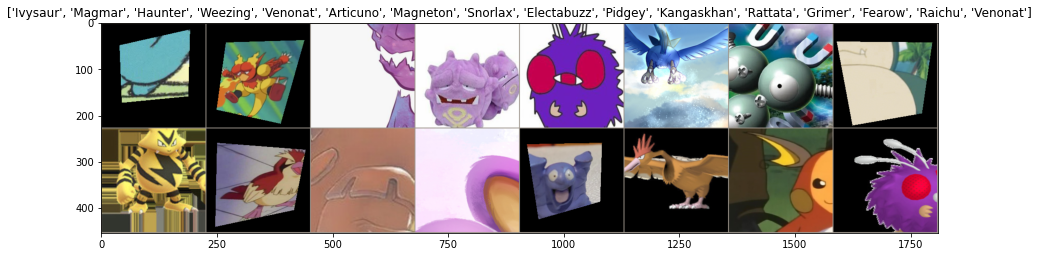

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # Convert from CHW to HWC (because pytorch)
    inp = inp.numpy().transpose((1, 2, 0))
    # De-normalize images from training data
    inp = train_std * inp + train_mean
    # Plot image
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data and show them as [image - pokémon name].
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 2. Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model of all time

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.

### 2.1 Stochastic Gradient Descent

Stochastic gradient descent (SGD) is an optimization algorithm that estimates the error gradient for the current state of the model using examples from the training dataset, then updates the weights of the model using the back-propagation of errors algorithm, referred to as simply backpropagation.

### 2.2 Learning rate and the importance of scheduling the learning rate.

The amount that the weights are updated during training is referred to as the step size or the _learning rate._

The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs

A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck.


### 2.3 Learning rate scheduler

A Learning rate scheduler is a predefined framework that adjusts the learning rate between epochs or iterations as the training progresses. We'll use _learning rate decay_: we select an initial learning rate, then gradually reduce it in accordance with a scheduler.

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # set model to training mode
            else:
                model.eval()  # set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            writer.add_scalar("Epoch_loss", epoch_loss, epoch)
            writer.add_scalar("Epoch_acc", epoch_acc, epoch)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
                              
            # Deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
 
    writer.flush()
    writer.close()
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

See all Pokémon names.

In [10]:
class_names

['Abra',
 'Aerodactyl',
 'Alakazam',
 'Arbok',
 'Arcanine',
 'Articuno',
 'Beedrill',
 'Bellsprout',
 'Blastoise',
 'Bulbasaur',
 'Butterfree',
 'Caterpie',
 'Chansey',
 'Charizard',
 'Charmander',
 'Charmeleon',
 'Clefable',
 'Clefairy',
 'Cloyster',
 'Cubone',
 'Dewgong',
 'Diglett',
 'Ditto',
 'Dodrio',
 'Doduo',
 'Dragonair',
 'Dragonite',
 'Dratini',
 'Drowzee',
 'Dugtrio',
 'Eevee',
 'Ekans',
 'Electabuzz',
 'Electrode',
 'Exeggcute',
 'Exeggutor',
 "Farfetch'd",
 'Fearow',
 'Flareon',
 'Gastly',
 'Gengar',
 'Geodude',
 'Gloom',
 'Golbat',
 'Goldeen',
 'Golduck',
 'Golem',
 'Graveler',
 'Grimer',
 'Growlithe',
 'Gyarados',
 'Haunter',
 'Hitmonchan',
 'Hitmonlee',
 'Horsea',
 'Hypno',
 'Ivysaur',
 'Jigglypuff',
 'Jolteon',
 'Jynx',
 'Kabuto',
 'Kabutops',
 'Kadabra',
 'Kakuna',
 'Kangaskhan',
 'Kingler',
 'Koffing',
 'Krabby',
 'Lapras',
 'Lickitung',
 'Machamp',
 'Machoke',
 'Machop',
 'Magikarp',
 'Magmar',
 'Magnemite',
 'Magneton',
 'Mankey',
 'Marowak',
 'Meowth',
 'Metapod',

### 2.4 Fine-tuning

Load a pretrained model and replace final fully connected layer (`nn.Linear`).

In [11]:
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features  # retrieve number of input features for the classifier

# Create a new fully connected layer:
# - Input features: number retrieved from the original classifier (1024 for ResNet)
# - Output features: number of classes (151).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

################# MobileNetV2 ###################
# model_ft = models.mobilenet_v2(pretrained=True)
# model_ft.classifier = nn.Linear(1280, 151)
#################################################

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Finally, train model.



In [12]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 3.7328 Acc: 0.2430
val Loss: 1.4363 Acc: 0.6832

Epoch 1/14
----------
train Loss: 1.5477 Acc: 0.6596
val Loss: 0.5720 Acc: 0.8651

Epoch 2/14
----------
train Loss: 0.9439 Acc: 0.7853
val Loss: 0.3451 Acc: 0.9210

Epoch 3/14
----------
train Loss: 0.7025 Acc: 0.8380
val Loss: 0.2633 Acc: 0.9335

Epoch 4/14
----------
train Loss: 0.5840 Acc: 0.8608
val Loss: 0.2196 Acc: 0.9388

Epoch 5/14
----------
train Loss: 0.5112 Acc: 0.8775
val Loss: 0.1991 Acc: 0.9530

Epoch 6/14
----------
train Loss: 0.4527 Acc: 0.8918
val Loss: 0.1824 Acc: 0.9601

Epoch 7/14
----------
train Loss: 0.3830 Acc: 0.9114
val Loss: 0.1550 Acc: 0.9627

Epoch 8/14
----------
train Loss: 0.3610 Acc: 0.9154
val Loss: 0.1504 Acc: 0.9618

Epoch 9/14
----------
train Loss: 0.3313 Acc: 0.9205
val Loss: 0.1527 Acc: 0.9636

Epoch 10/14
----------
train Loss: 0.3268 Acc: 0.9249
val Loss: 0.1474 Acc: 0.9627

Epoch 11/14
----------
train Loss: 0.3035 Acc: 0.9298
val Loss: 0.1463 Acc: 0.9618

Ep

## 3. Predictions on the Test Set
Let's run the model on the test set to obtain loss and accuracy.

In [14]:
eval_losses = []
eval_acc = []

model_ft.eval()
running_loss = 0
correct = 0
total = 0

# Since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders["test"]:
        images, labels = data[0].to(device), data[1].to(device)
        
        # Calculate outputs by running images through the network
        outputs = model_ft(images)
        loss = criterion(outputs,labels)
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
   
    test_loss = running_loss / len(dataloaders["test"])
    acc = 100. * correct / total

    eval_losses.append(test_loss)
    eval_acc.append(acc)

    print(f"Test Loss: {test_loss:.3f}  | Accuracy: {acc:.3f}") 

Test Loss: 0.110  | Accuracy: 97.088


Let's visualize some predictions on the test set.

In [46]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = fig.add_subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"Predicted: {class_names[preds[j]]}")
                # From CHW to HWC
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = train_std * img + train_mean
                img = np.clip(img, 0, 1)
                ax.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

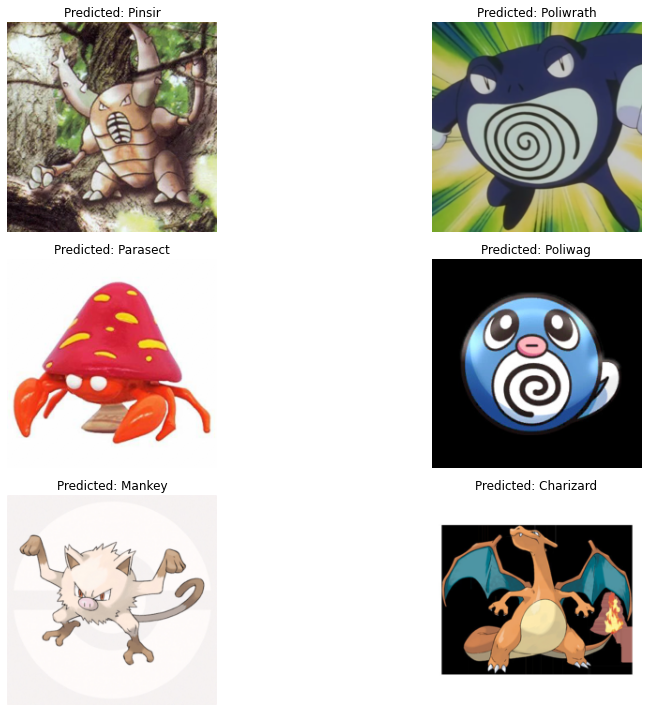

In [51]:
visualize_model(model_ft)
plt.tight_layout()
plt.show()

## 4. Conversion to TFLite

First of all, we save all model weights.

In [17]:
torch.save(model_ft.state_dict(), "/app/src/resnet152")

Then, we export the model to the ONNX format. Since it requires the parameters to be on the CPU, we first load them into a proxy model.

In [54]:
proxy = models.resnet152(pretrained=False)
proxy.fc = nn.Linear(num_ftrs, len(class_names))

############# MobileNetV2 ###############
# proxy.classifier = nn.Linear(1280, 151)
#########################################

proxy.load_state_dict(torch.load("/app/src/resnet152", map_location=torch.device("cpu")))

proxy.eval()
dummy_input = torch.randn(1, 3, 224, 224)
input_names = ["actual_input"]
output_names = ["output"]
torch.onnx.export(
    proxy,
    dummy_input,
    "/app/src/resnet152.onnx",
    verbose=False,
    input_names=input_names,
    output_names=output_names,
    export_params=True
)

Convert to tensorflow model (`pb`).

In [7]:
!onnx-tf convert -i /app/src/resnet152.onnx -o /app/src/resnet152.pb

2022-01-09 21:42:32,182 - onnx-tf - INFO - Start converting onnx pb to tf saved model
2022-01-09 21:42:32.457139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 21:42:32.460353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 21:42:32.460661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 21:42:32.461168: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To e

Convert model to `.tflite`.

In [8]:
!tflite_convert --saved_model_dir=/app/src/resnet152.pb --output_file=/app/src/resnet152.tflite

2022-01-09 21:43:25.400741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 21:43:25.404344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 21:43:25.404546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 21:43:26.147469: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## 5. Prediction of Real-world Images

Set up variables for prediction.

In [2]:
# Load LabelEncoder
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load("/app/src/best_classes.npy")

# Mean and std of training set
train_mean = np.array([0.6196016, 0.5909941, 0.55595106])
train_std = np.array([0.23812556, 0.23278241, 0.24086562])

### 5.1 Prediction with PyTorch
Load PyTorch model.

In [3]:
device = torch.device("cpu")

# mobilenet = models.mobilenetv2(pretrained=False)
# mobilenet.classifier = nn.Linear(1280, 151)
# model = torch.load('/app/src/mobilenetv2', map_location=device)
# mobilenet.load_state_dict(model)
# mobilenet.eval()
model_ft = models.resnet152(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 151)
model = torch.load("/app/src/resnet152", map_location=device)
model_ft.load_state_dict(model)
model_ft.eval()

test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

Apply transforms to image and make predictions.

In [9]:
# Load sample image
pic = '/app/src/images/0.jpg'
pic = Image.open(pic)
pic = pic.resize((224, 224), Image.ANTIALIAS)
image_tensor = test_transforms(pic).float()
image_tensor = image_tensor.unsqueeze_(0)
with torch.no_grad():
    output = model_ft(image_tensor)

Add Softmax post training.

In [10]:
sm = nn.Softmax(dim=1)
with torch.no_grad():
    probs = sm(output)

Display top predictions.

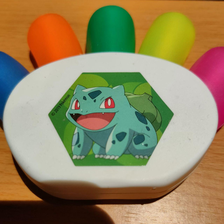

Bulbasaur: 92.77%
Ivysaur: 4.37%
Venusaur: 0.68%
Squirtle: 0.51%
Metapod: 0.27%


In [11]:
(top_k_scores, top_k_idx) = torch.topk(probs, 5)
top_k_scores = top_k_scores.numpy()
top_k_scores = np.squeeze(top_k_scores, axis=0)
top_k_idx = np.squeeze(top_k_idx.numpy(), axis=0)
top_k_labels = label_encoder.inverse_transform(top_k_idx)

pic.show()
print("\n".join([f"{pred}: {score:.2%}" for (pred, score) in zip(top_k_labels, top_k_scores)]))

### 5.2 Prediction with TFLite

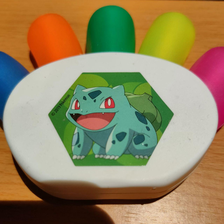

Bulbasaur: 94.08%
Ivysaur: 4.44%
Venusaur: 0.69%
Squirtle: 0.52%
Metapod: 0.27%


In [16]:
import tflite_runtime.interpreter as tflite

# Predicts num_top_pokemon from image_file, using a tflite model
TFLITE_MODEL = "/app/src/resnet152.tflite"
interpreter = tf.lite.Interpreter(TFLITE_MODEL)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load sample image
pic = '/app/src/images/0.jpg'
pic = Image.open(pic)

pic = pic.resize((224, 224), Image.ANTIALIAS)
pic.show()
pic = np.asarray(pic, dtype=np.float32)
pic = np.expand_dims(pic, axis=0)
pic /= 255 
pic = (pic - train_mean) / train_std
pic = np.transpose(pic, [0, 3, 1, 2])

input_tensor = np.array(pic, dtype=np.float32)
# Load the TFLite model and allocate tensors.
interpreter.set_tensor(input_details[0]['index'], input_tensor)
interpreter.invoke()

# Get output
output_data = interpreter.get_tensor(output_details[0]['index'])

results = np.squeeze(output_data, axis=0)
top_k_idx = np.argsort(results)[-num_top_pokemon:][::-1]
top_k_scores = results[top_k_idx]
top_k_labels = label_encoder.inverse_transform(top_k_idx)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

top_k_scores = softmax(top_k_scores)

print("\n".join([f"{pred}: {score:.2%}" for (pred, score) in zip(top_k_labels, top_k_scores)]))
